## Introduction and Motivation

#### General Area => Reinforcement Learning (RL)

Reinforcement Learning is a part of machine learning where an agent learns to make decisions by interacting with its environment. The goal is to find the best way (or policy) to act so that the agent gains the most reward over time.

#### Why This Area Is Important:
1. Wide Use: RL is used in many fields like robotics (for moving and handling objects), self-driving cars, game AI, and managing resources.
2. Learning by Doing: It lets systems learn by trying different actions and learning from the results, which is useful when it is hard to program every detail.
3. Real-World Impact: Many problems in real life involve making a series of decisions under uncertainty, and RL helps to solve these problems.

#### Brief Summary of the Problem:
In this project, we train an agent to move in a grid that has a start point, obstacles, and a goal. The agent can move up, down, left, or right. It receives a small negative reward for every move, a larger penalty for invalid moves (like hitting a wall), and a positive reward for reaching the goal. Over time, the agent learns the best path from the start to the goal.

#### Why This Problem Is Important:
This grid navigation task is an example in RL. It is good for understanding and visualize also shows important challenges like choosing between exploring new paths and using the best known path.

----



## Problem Description

#### Environment Layout:
* The environment is a 2D grid.
* Each cell in the grid can be a start (S), a goal (G), an obstacle (X), or an empty space.
* The agent’s location is given by its (row, column) position.

#### Objective:
* The agent must move from the start to the goal while avoiding obstacles.

#### Assumptions:
1. The grid does not change during one run (the positions of obstacles and the goal are fixed).
2. The agent always knows where it is.
3. Actions are clear: if an action is invalid (for example, if it leads to a wall or obstacle), the agent gets a penalty and stays in the same place.
4. The reward structure is defined as:
	* Step Cost: -1 for every move (to encourage shorter paths).
	* Invalid Move Penalty: -5 if the agent moves out of bounds or into an obstacle.
	* Goal Reward: +10 for reaching the goal (which becomes +9 after the step cost is subtracted).

---

* The project is built step-by-step:
	1. Set up the environment.
	2. Implement Q-Learning.
	4. Implement SARSA.
	5. Implement DQN.
	6. Implement Double DQN.
	7. Comparison and analysis.


---

## Import used Libraries:

In [225]:
import numpy as np
import matplotlib.pyplot as plt

import random

import torch
import torch.nn as nn
import torch.optim as optim


## Grid World Environment Preparation:

In [226]:
class GridWorldEnv:
    def __init__(self, grid):
        # Initializes the grid environment => 'S' = Start, 'G' = Goal, 'X' = Obstacle, ' ' = Empty space.
        self.grid = grid
        self.rows = len(grid)
        self.cols = len(grid[0])
        self.start_pos = None
        
        # Find starting position
        for i in range(self.rows):
            for j in range(self.cols):
                if grid[i][j] == 'S':
                    self.start_pos = (i, j)
                    break
            if self.start_pos is not None:
                break
        
        if self.start_pos is None:
            raise ValueError("There is no Starting point marked with 'S'.")
        
        self.reset()

    def reset(self):
        # Resets the environment to the starting state and returns the starting state (agent's position).
        self.agent_pos = self.start_pos
        return self.agent_pos

    def step(self, action):
        # Executes an action in the environment => 0 = Up, 1 = Right, 2 = Down, 3 = Left and returns: (new_state, reward, done, info)
        row, col = self.agent_pos
        
        # Determine new position based on the action
        if action == 0:         # Up
            new_row, new_col = row - 1, col
        elif action == 1:       # Right
            new_row, new_col = row, col + 1
        elif action == 2:       # Down
            new_row, new_col = row + 1, col
        elif action == 3:       # Left
            new_row, new_col = row, col - 1
        else:
            raise ValueError("Invalid action.")
        
        # Check if new position is outside the grid boundaries
        if new_row < 0 or new_row >= self.rows or new_col < 0 or new_col >= self.cols:
            reward = -5  # Penalty for invalid move
            done = False
            return self.agent_pos, reward, done, {}
        
        # Check if new position is an obstacle
        if self.grid[new_row][new_col] == 'X':
            reward = -5  # Penalty for hitting an obstacle
            done = False
            return self.agent_pos, reward, done, {}
        
        # Valid move: update agent's position
        self.agent_pos = (new_row, new_col)
        
        # Check if goal is reached
        if self.grid[new_row][new_col] == 'G':
            reward = 10  # Goal reward (net +9 after step cost cause of -1 per move)
            done = True
        else:
            reward = -1  # Step cost for a valid move
            done = False
        
        return self.agent_pos, reward, done, {}

    def render(self):
        # Prints a representation of the grid, showing the agent's current position with 'A'.
        rendered_grid = []
        for i in range(self.rows):
            row_str = ""
            for j in range(self.cols):
                if (i, j) == self.agent_pos:
                    row_str += "A "  # Agent's position
                else:
                    row_str += self.grid[i][j] + " "
            rendered_grid.append(row_str)
        for row in rendered_grid:
            print(row)


# Functions to create grid layouts

def create_grid_8x8():
    """
    A more complex 8x8 grid with additional obstacles.
    'S' = Start, 'G' = Goal, 'X' = Obstacle, ' ' = Empty space
    """
    grid = [
        ['S', 'X', ' ', ' ', 'X', ' ', ' ', 'X'],
        [' ', ' ', 'X', ' ', ' ', ' ', 'X', ' '],
        [' ', 'X', ' ', ' ', 'X', 'X', ' ', ' '],
        [' ', ' ', 'X', ' ', ' ', ' ', 'X', ' '],
        ['X', ' ', ' ', ' ', 'X', ' ', ' ', ' '],
        [' ', 'X', ' ', ' ', ' ', 'X', ' ', ' '],
        ['X', ' ', 'X', ' ', ' ', ' ', ' ', ' '],
        [' ', ' ', ' ', 'X', ' ', ' ', 'X', 'G']
    ]
    return grid

def create_grid_11x11():
    """
    A more complex 11x11 grid with additional obstacles.
    """
    grid = [
        ['S', ' ', 'X', ' ', 'X', ' ', 'X', ' ', 'X', ' ', ' '],
        [' ', ' ', ' ', 'X', ' ', 'X', ' ', 'X', ' ', 'X', ' '],
        [' ', 'X', ' ', ' ', ' ', ' ', 'X', ' ', 'X', ' ', 'X'],
        [' ', ' ', 'X', ' ', 'X', 'X', ' ', ' ', ' ', ' ', ' '],
        ['X', ' ', ' ', 'X', ' ', ' ', ' ', 'X', 'X', ' ', ' '],
        [' ', 'X', ' ', ' ', 'X', ' ', ' ', ' ', ' ', ' ', ' '],
        ['X', ' ', 'X', ' ', ' ', ' ', 'X', ' ', ' ', ' ', 'X'],
        [' ', ' ', ' ', ' ', 'X', ' ', ' ', ' ', 'X', 'X', ' '],
        [' ', 'X', ' ', 'X', ' ', ' ', 'X', ' ', ' ', ' ', ' '],
        ['X', ' ', 'X', ' ', 'X', ' ', ' ', ' ', 'X', ' ', ' '],
        [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'G']
    ]
    return grid

def create_grid_14x14():
    """
    A more complex 14x14 grid with additional obstacles.
    """
    grid = [
        ['S', ' ', 'X', 'X', ' ', ' ', ' ', ' ', 'X', ' ', 'X', ' ', ' ', ' '],
        [' ', ' ', ' ', ' ', 'X', ' ', 'X', ' ', ' ', ' ', ' ', 'X', ' ', ' '],
        [' ', ' ', 'X', ' ', ' ', 'X', ' ', 'X', ' ', ' ', ' ', ' ', 'X', ' '],
        ['X', ' ', ' ', 'X', ' ', ' ', ' ', 'X', ' ', ' ', 'X', ' ', ' ', ' '],
        [' ', ' ', 'X', ' ', 'X', ' ', ' ', ' ', 'X', ' ', ' ', ' ', ' ', ' '],
        [' ', 'X', ' ', ' ', ' ', ' ', 'X', ' ', ' ', ' ', 'X', 'X', ' ', ' '],
        [' ', ' ', 'X', ' ', 'X', ' ', ' ', ' ', 'X', ' ', ' ', ' ', ' ', ' '],
        [' ', 'X', ' ', ' ', 'X', 'X', ' ', ' ', ' ', ' ', ' ', ' ', 'X', ' '],
        ['X', ' ', ' ', ' ', ' ', ' ', 'X', ' ', ' ', ' ', 'X', ' ', ' ', ' '],
        [' ', ' ', 'X', ' ', ' ', ' ', ' ', ' ', ' ', 'X', ' ', ' ', ' ', ' '],
        [' ', 'X', ' ', ' ', ' ', ' ', 'X', ' ', ' ', ' ', ' ', 'X', ' ', ' '],
        [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'X', ' ', 'X', ' ', ' ', ' '],
        ['X', ' ', 'X', ' ', ' ', ' ', ' ', 'X', ' ', ' ', ' ', ' ', ' ', ' '],
        [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'G']
    ]
    return grid

def create_grid_17x17():
    """
    A more complex 17x17 grid with a set of obstacles placed at various locations.
    'S' at (0,0), 'G' at (16,16).
    """
    grid = [[' ' for _ in range(17)] for _ in range(17)]
    # Start and Goal
    grid[0][0] = 'S'
    grid[16][16] = 'G'
    
    # Define obstacles (row, col)
    obstacles = [
        (1, 3), (2, 2), (2, 8), (3, 5), (3, 12), (4, 6), (5, 1), (5, 9), 
        (6, 14), (7, 7), (8, 3), (8, 10), (9, 0), (9, 5), (10, 2), (10, 12),
        (11, 8), (12, 1), (13, 4), (14, 10), (15, 3), (15, 13)
    ]
    
    for r, c in obstacles:
        grid[r][c] = 'X'
    return grid

def create_grid_20x20():
    """
    A more complex 20x20 grid with a set of obstacles placed at various locations.
    'S' at (0,0), 'G' at (19,19).
    """
    grid = [[' ' for _ in range(20)] for _ in range(20)]
    # Start and Goal
    grid[0][0] = 'S'
    grid[19][19] = 'G'
    
    # Define obstacles (row, col)
    obstacles = [
        (1, 1), (2, 2), (2, 15), (3, 5), (4, 4), (4, 9), (5, 10), (6, 8),
        (7, 7), (8, 14), (9, 10), (10, 3), (10, 16), (12, 6), (12, 14),
        (14, 18), (15, 15), (16, 12), (17, 5), (17, 12)
    ]
    
    for r, c in obstacles:
        grid[r][c] = 'X'
    return grid


### Env Test using render():

In [227]:
print("Demonstrating the 8*8 Grid Environment:")
grid = create_grid_8x8()
env = GridWorldEnv(grid)
print()
print("Initial Environment:")
env.render()
print()
print("Taking action 'Right' (action=1):")
state, reward, done, _ = env.step(1)
env.render()
print(f"State: {state}, Reward: {reward}, Done: {done}")

Demonstrating the 8*8 Grid Environment:

Initial Environment:
A X     X     X 
    X       X   
  X     X X     
    X       X   
X       X       
  X       X     
X   X           
      X     X G 

Taking action 'Right' (action=1):
A X     X     X 
    X       X   
  X     X X     
    X       X   
X       X       
  X       X     
X   X           
      X     X G 
State: (0, 0), Reward: -5, Done: False


---


## Solution Approach

We use four methods of Reinforcement Learning to solve this problem:
1. Tabular Q-Learning:
- Method:

	* Uses a table (Q-table) to store and update values for each state-action pair.
	* The agent learns by updating the table based on the rewards it gets.

- Why Q-Learning?
	* It is simple and works well in small grids.
	* The learned policy is easy to understand and check.

2. Tabular SARSA:
- Method:
	* Uses a table (Q-table) like Q-Learning, but updates it using the action that was actually taken.
	* The agent learns by updating the table with the value of the action it actually performs.
- Why SARSA?
	* It considers the next action in the update, which can lead to smoother learning.
	* It is useful when you want to control exploration more directly.

3. Deep Q-Network (DQN):
- Method:
	- Uses a neural network to estimate Q-values for each action given a state.
	- Uses techniques like experience replay and a target network to make training more stable.
- Why DQN?
	- It works better in larger grids where a table would be too big.
	- It shows how we can use function approximation to learn in complex situations.
	
4. Double DQN:
- Method:
	- Similar to DQN but uses two networks to reduce overestimation of Q-values.
	- One network selects the best action and the other evaluates its value.
- Why Double DQN?
	- It helps to reduce bias in the value estimates.
	- It can improve performance when the environment is more challenging.




In [ ]:
# General Hyperparameters: (we set them here to use the same values for all 4 models!)
num_episodes = 3000
max_steps = 2000

## Q-learning Implementation:


In [229]:
class QLearningAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.99, epsilon=1.0, 
                 epsilon_decay=0.995, epsilon_min=0.01):
        self.Q = {}  # Dictionary for Q-values -> key=state, value=array of action values
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def get_action(self, state):
        # Initialize Q-values for unseen states
        if state not in self.Q:
            self.Q[state] = np.zeros(len(self.actions))
        # Explore with probability epsilon
        if np.random.random() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return np.argmax(self.Q[state])
    
    def update(self, state, action, reward, next_state, done):
        if state not in self.Q:
            self.Q[state] = np.zeros(len(self.actions))
        if next_state not in self.Q:
            self.Q[next_state] = np.zeros(len(self.actions))
        best_next_action = np.argmax(self.Q[next_state])
        td_target = reward + self.gamma * self.Q[next_state][best_next_action] * (not done)
        td_error = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error


### Training Function: Trains the Q-learning agent on the provided environment.



In [230]:
def train_q_learning(env, agent, num_episodes, max_steps):
    rewards_per_episode = []
    success_rate = []
    successes = 0
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        step = 0
        while not done and step < max_steps:
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step += 1

        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        rewards_per_episode.append(total_reward)

        if done and reward == 10:
            successes += 1
        success_rate.append(successes / (episode + 1))
    return rewards_per_episode, success_rate

### Training on Different Grid Sizes


Training on 8x8 grid...
Training on 11x11 grid...
Training on 14x14 grid...
Training on 17x17 grid...
Training on 20x20 grid...


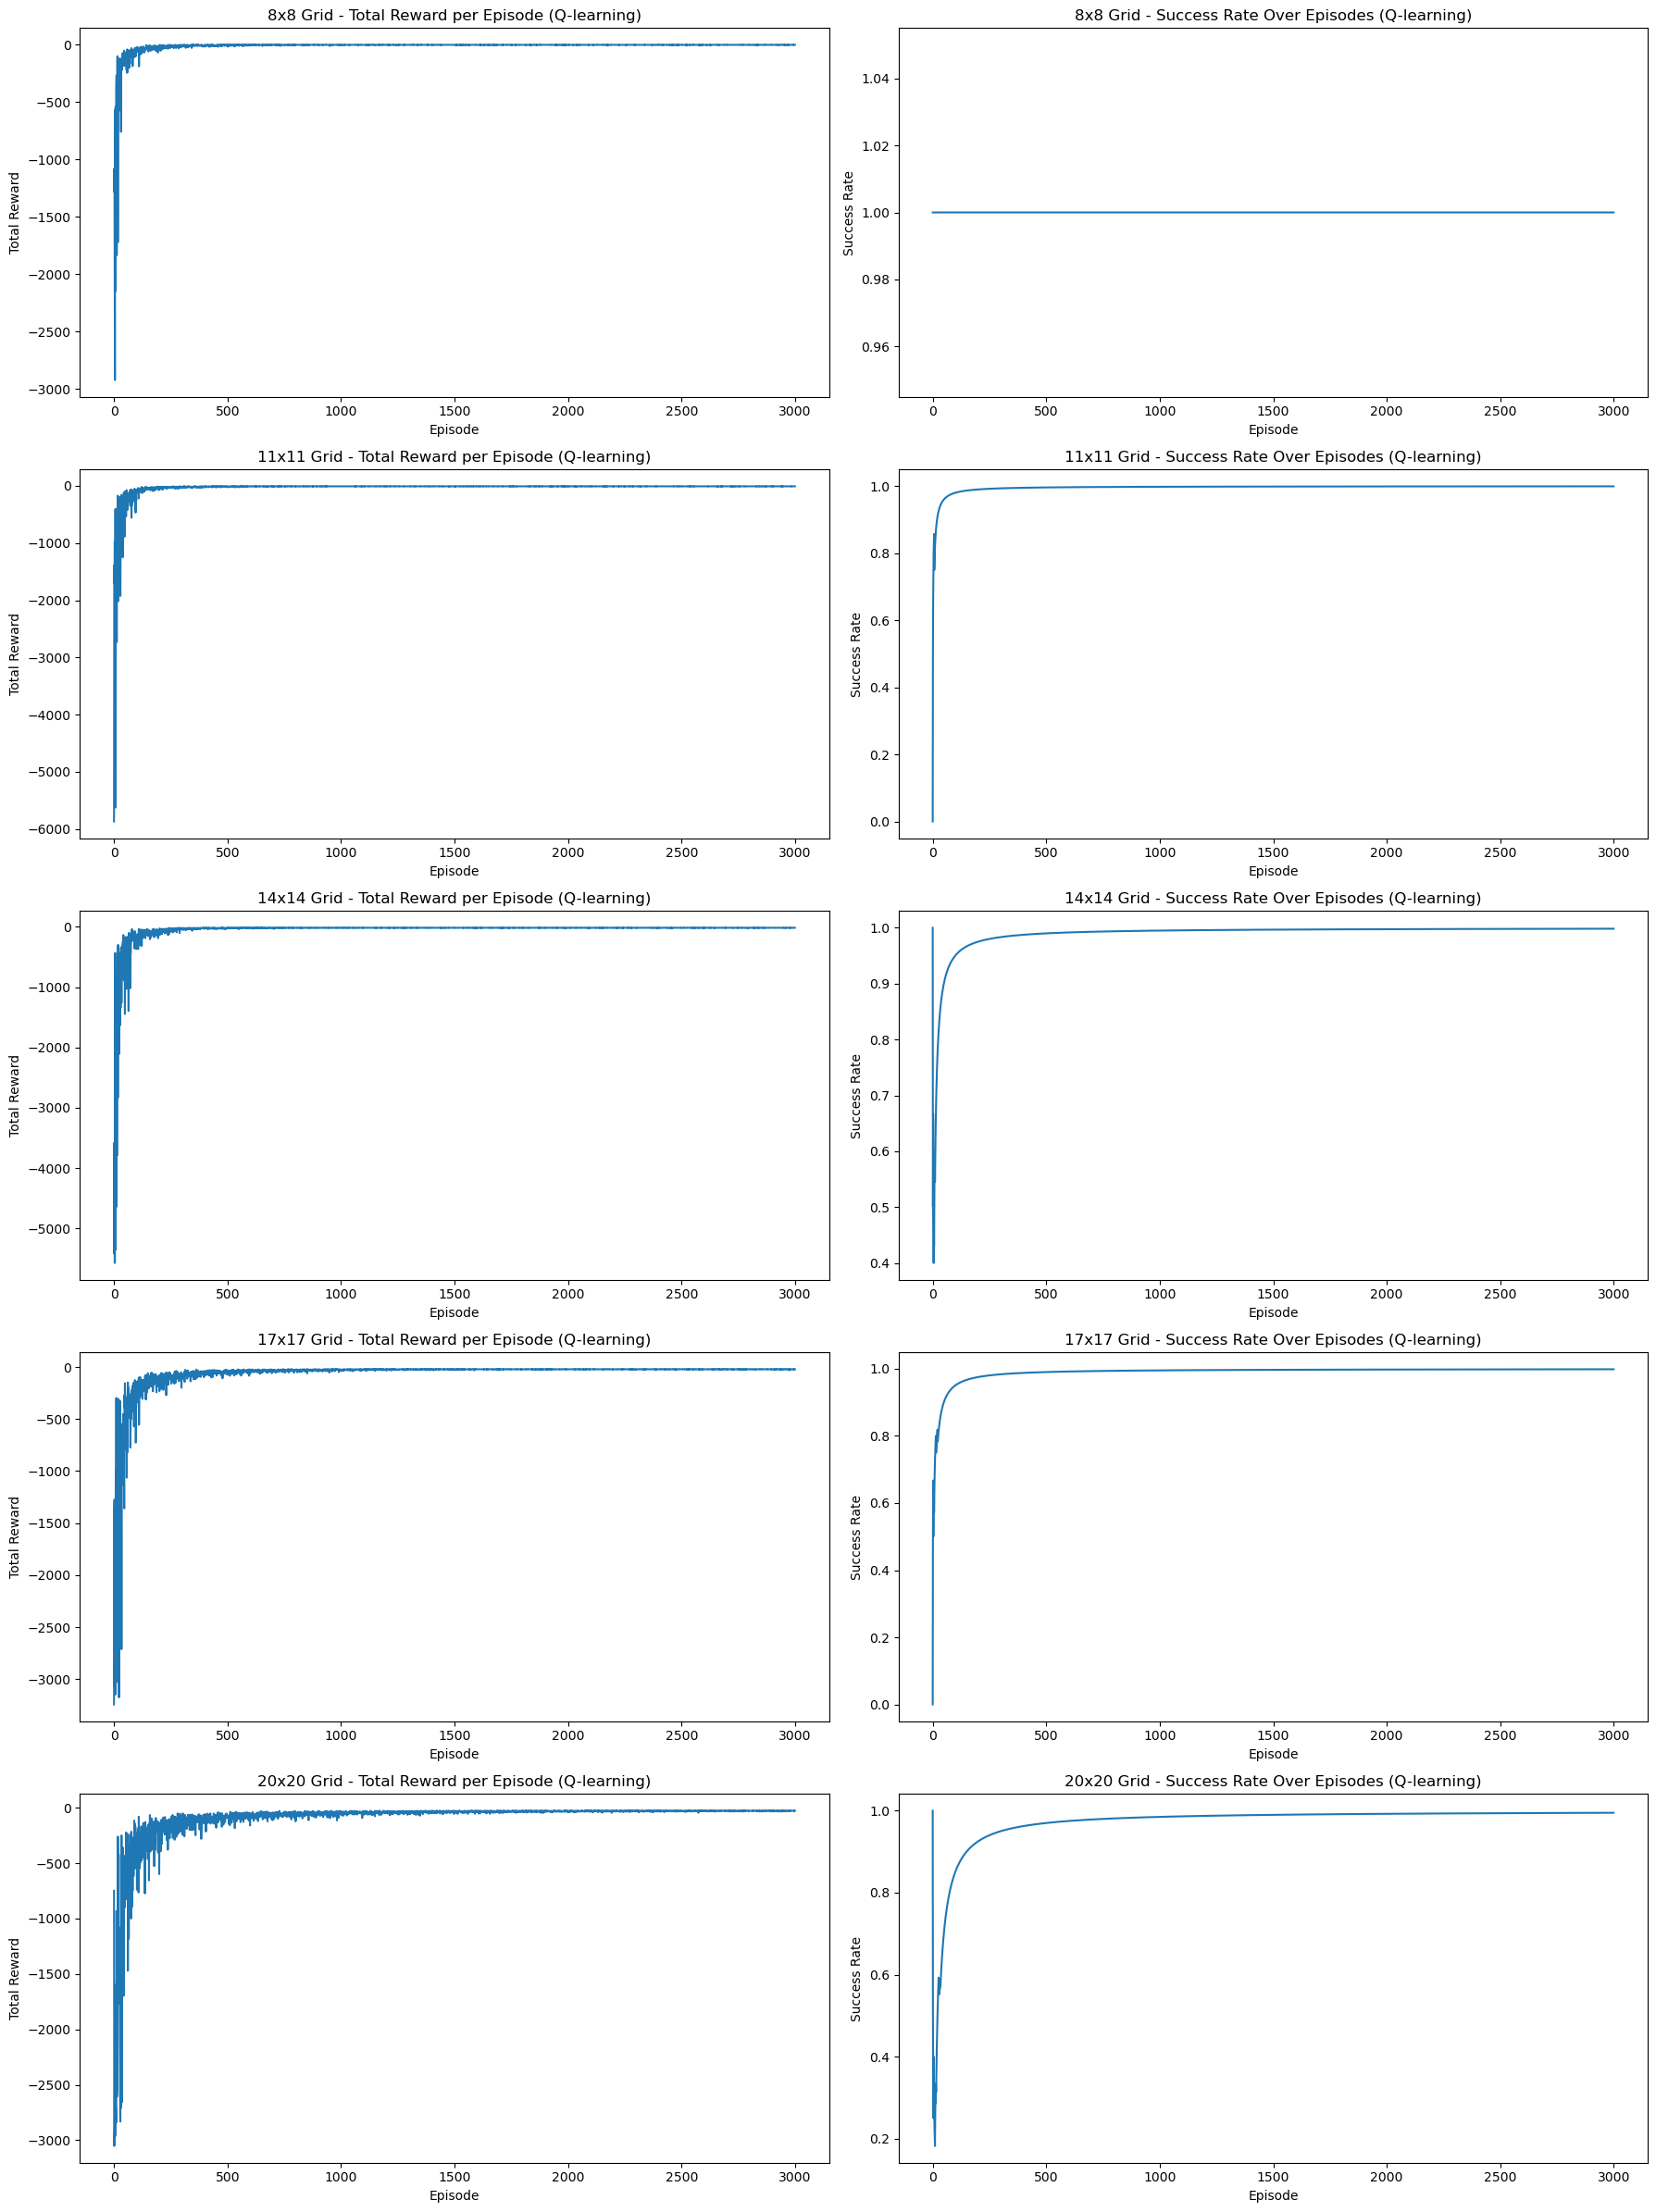

In [231]:
grids = {
    "8x8" : create_grid_8x8(),
    "11x11" : create_grid_11x11(),
    "14x14" : create_grid_14x14(),
    "17x17" : create_grid_17x17(),
    "20x20" : create_grid_20x20()
}

results = {}

for grid_name, grid in grids.items():
    print(f"Training on {grid_name} grid...")
    env = GridWorldEnv(grid)
    agent = QLearningAgent(actions=[0, 1, 2, 3], alpha=0.1, gamma=0.99, 
                           epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01)
    rewards, success_rate = train_q_learning(env, agent, num_episodes, max_steps)
    results[grid_name] = {'rewards': rewards, 'success_rate': success_rate}

# Plot
fig, axes = plt.subplots(len(grids), 2, figsize=(18, 24))  

for idx, grid_name in enumerate(results.keys()):
    rewards = results[grid_name]['rewards']
    success_rate = results[grid_name]['success_rate']
    
    axes[idx, 0].plot(rewards)
    axes[idx, 0].set_title(f"{grid_name} Grid - Total Reward per Episode (Q-learning)")
    axes[idx, 0].set_xlabel("Episode")
    axes[idx, 0].set_ylabel("Total Reward")
    
    axes[idx, 1].plot(success_rate)
    axes[idx, 1].set_title(f"{grid_name} Grid - Success Rate Over Episodes (Q-learning)")
    axes[idx, 1].set_xlabel("Episode")
    axes[idx, 1].set_ylabel("Success Rate")

plt.tight_layout()
plt.show()

## SARSA Implementation


In [232]:
class SARSAAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.99, epsilon=1.0, 
                 epsilon_decay=0.995, epsilon_min=0.01):
        self.Q = {}  # Q-table: key=state (tuple), value=array of action-values.
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def get_action(self, state):
        if state not in self.Q:
            self.Q[state] = np.zeros(len(self.actions))
        if np.random.random() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return np.argmax(self.Q[state])
    
    def update(self, state, action, reward, next_state, next_action, done):
        if state not in self.Q:
            self.Q[state] = np.zeros(len(self.actions))
        if next_state not in self.Q:
            self.Q[next_state] = np.zeros(len(self.actions))
        # update rule:
        # Q(s,a) = Q(s,a) + alpha * (reward + gamma * Q(s',a') - Q(s,a))
        target = reward + self.gamma * self.Q[next_state][next_action] * (not done)
        self.Q[state][action] += self.alpha * (target - self.Q[state][action])

## Training Function:


In [233]:
def train_sarsa(env, agent, num_episodes, max_steps):
    rewards_per_episode = []
    success_rate = []
    successes = 0

    for episode in range(num_episodes):
        state = env.reset()
        action = agent.get_action(state)
        total_reward = 0
        done = False
        step = 0
        
        while not done and step < max_steps:
            next_state, reward, done, _ = env.step(action)
            if not done:
                next_action = agent.get_action(next_state)
            else:
                next_action = 0  # Dummy value; won't affect update because (not done) is 0.
            
            agent.update(state, action, reward, next_state, next_action, done)
            state = next_state
            action = agent.get_action(state) if not done else None
            total_reward += reward
            step += 1
        
        # Decay epsilon
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        rewards_per_episode.append(total_reward)

        if done and reward == 10:
            successes += 1
        success_rate.append(successes / (episode + 1))
    
    return rewards_per_episode, success_rate

### Training on Different Grid Sizes:


Training on 8x8 grid using SARSA...
Training on 11x11 grid using SARSA...
Training on 14x14 grid using SARSA...
Training on 17x17 grid using SARSA...
Training on 20x20 grid using SARSA...


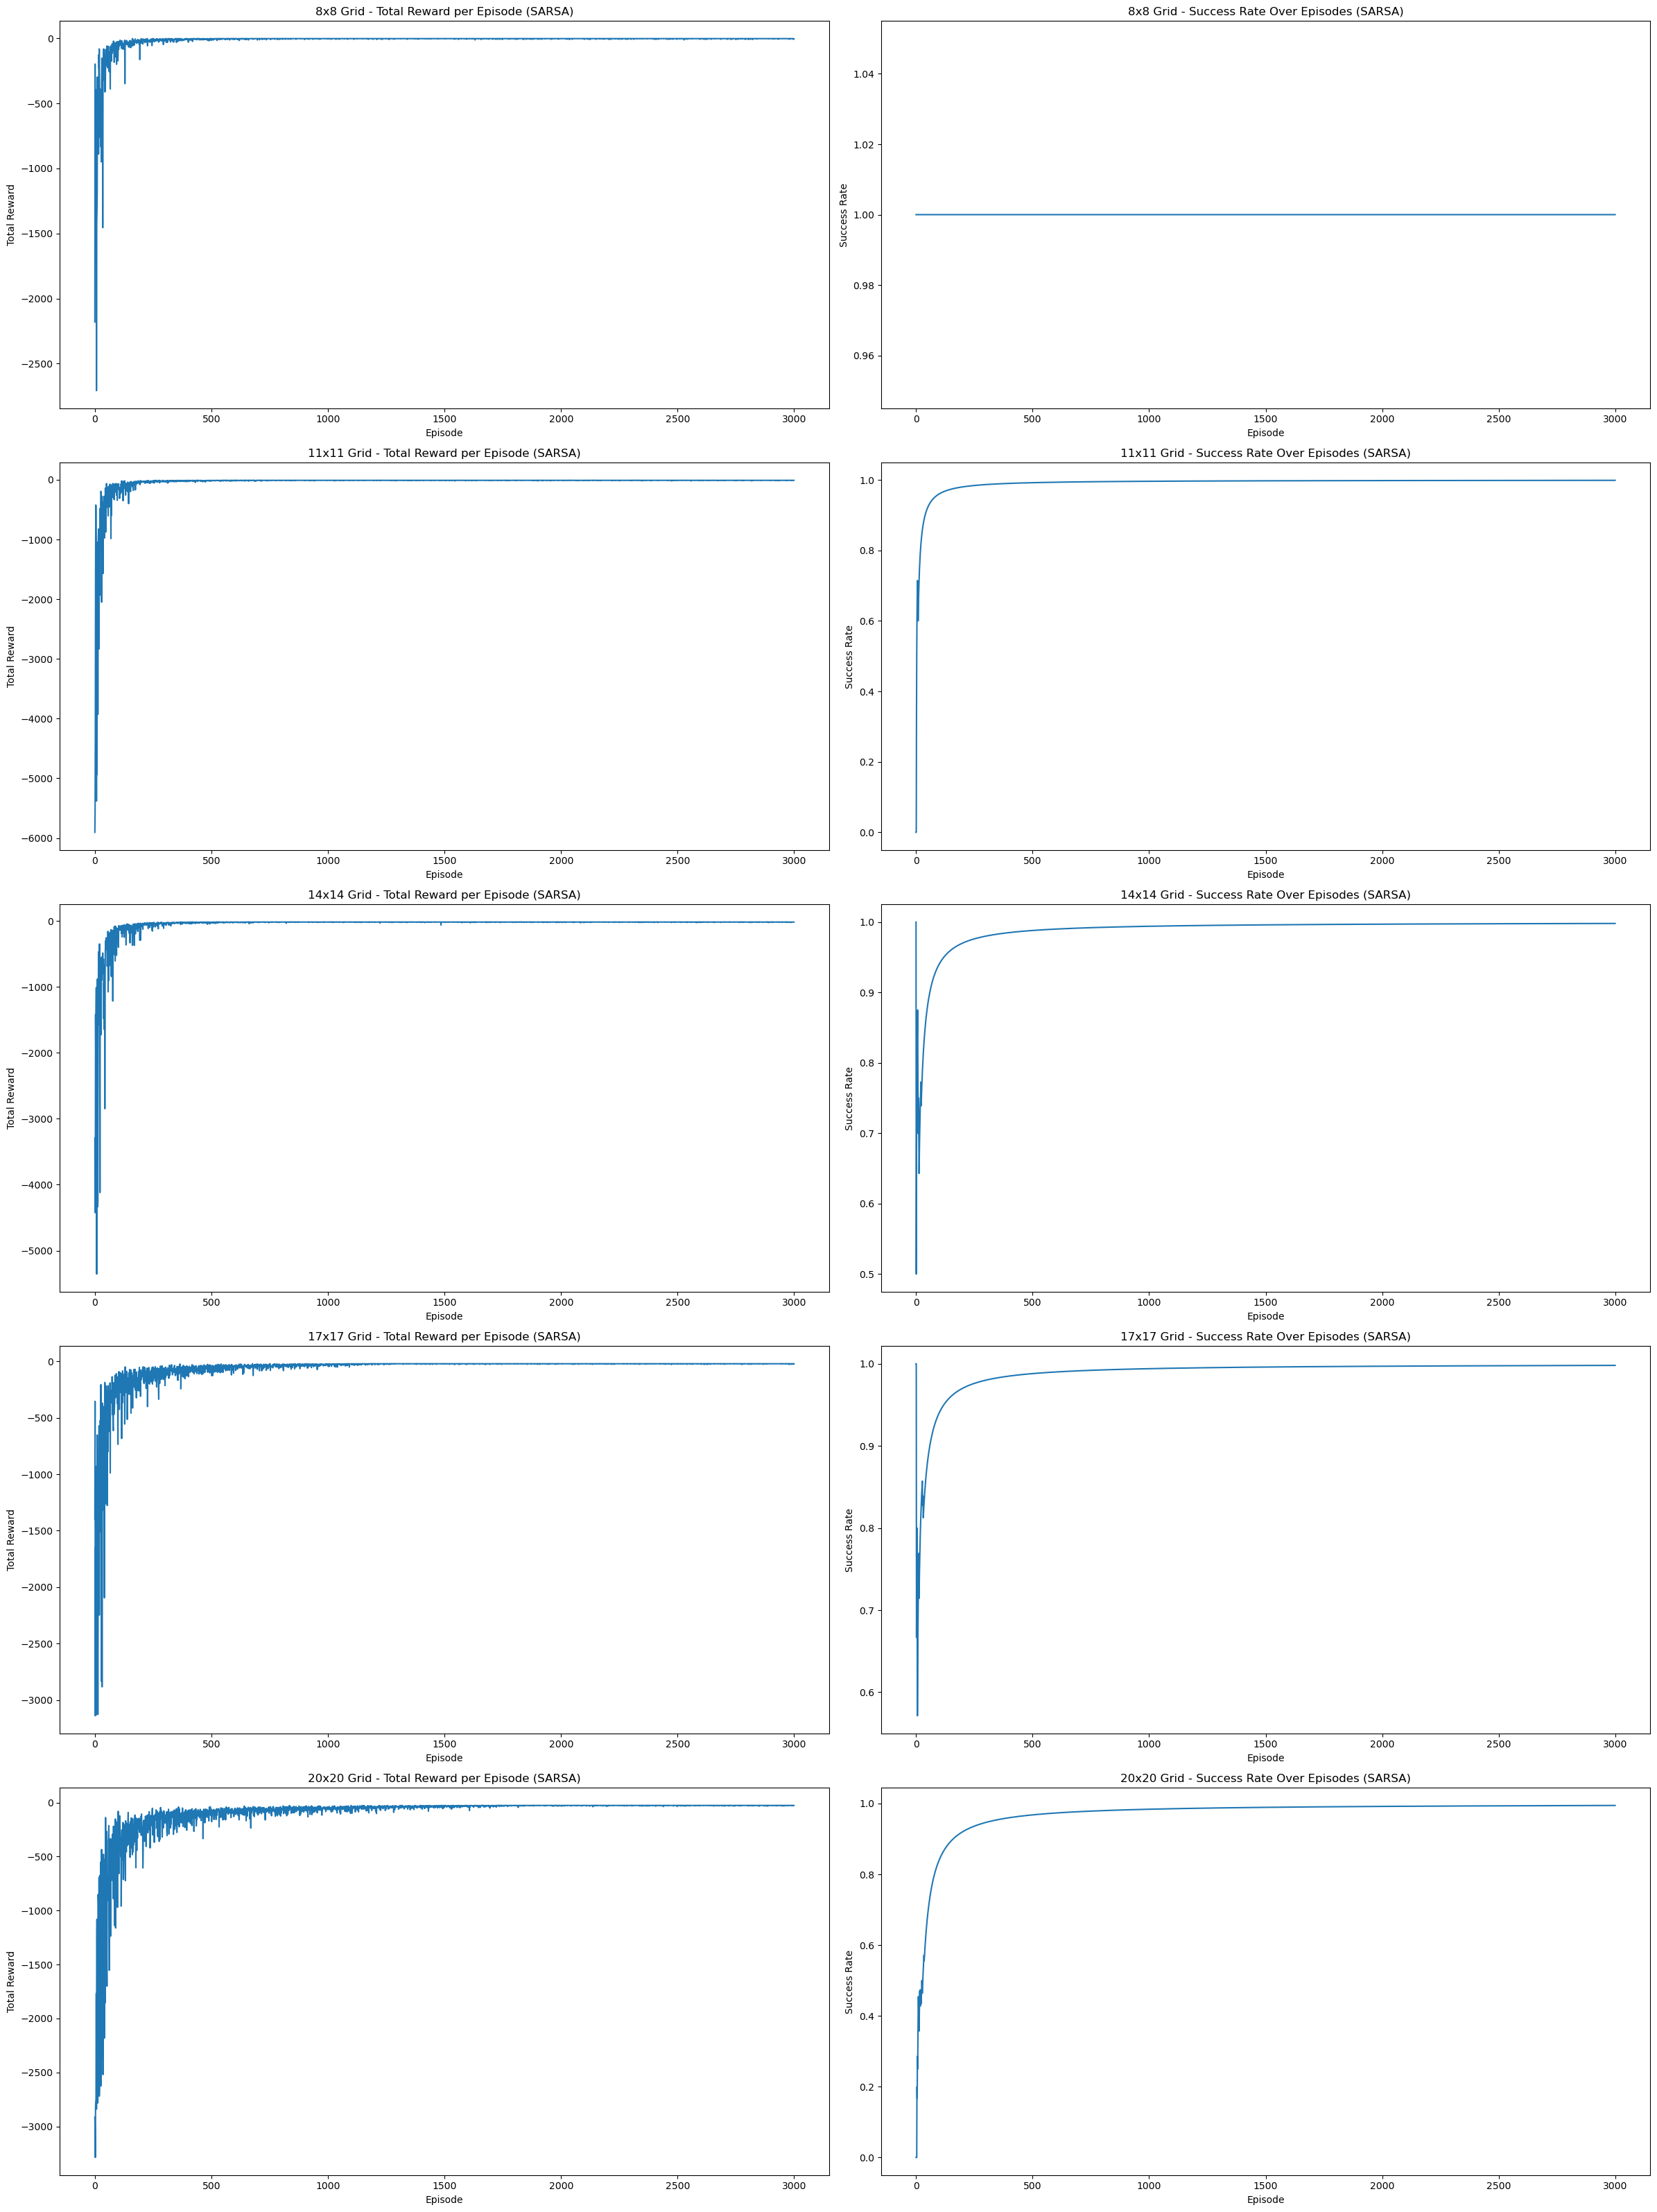

In [234]:
grids = {
    "8x8" : create_grid_8x8(),
    "11x11" : create_grid_11x11(),
    "14x14" : create_grid_14x14(),
    "17x17" : create_grid_17x17(),
    "20x20" : create_grid_20x20()
}

results = {}

for grid_name, grid in grids.items():
    print(f"Training on {grid_name} grid using SARSA...")
    env = GridWorldEnv(grid)
    agent = SARSAAgent(actions=[0, 1, 2, 3], alpha=0.1, gamma=0.99, 
                       epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01)
    rewards, success_rate = train_sarsa(env, agent, num_episodes, max_steps)
    results[grid_name] = {'rewards': rewards, 'success_rate': success_rate}

# Plot
fig, axes = plt.subplots(len(grids), 2, figsize=(24, 32)) 

for idx, grid_name in enumerate(results.keys()):
    rewards = results[grid_name]['rewards']
    success_rate = results[grid_name]['success_rate']
    
    axes[idx, 0].plot(rewards)
    axes[idx, 0].set_title(f"{grid_name} Grid - Total Reward per Episode (SARSA)")
    axes[idx, 0].set_xlabel("Episode")
    axes[idx, 0].set_ylabel("Total Reward")
    # Column 2: Success Rate Over Episodes
    axes[idx, 1].plot(success_rate)
    axes[idx, 1].set_title(f"{grid_name} Grid - Success Rate Over Episodes (SARSA)")
    axes[idx, 1].set_xlabel("Episode")
    axes[idx, 1].set_ylabel("Success Rate")

plt.tight_layout()
plt.show()

## DQN Implementation:

In [235]:
# Replay Buffer for Experience Replay
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

# Q-Network (Neural Network) Definition
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
        
    def forward(self, x):
        return self.fc(x)

### Agent Implementation:


In [236]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, buffer_capacity=10000, batch_size=64, gamma=0.99,
                 lr=1e-3, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, target_update_freq=10):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.target_update_freq = target_update_freq
        self.update_count = 0
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayBuffer(buffer_capacity)
        
    def select_action(self, state):
        # Convert state (tuple, e.g., (row, col)) into a torch tensor of shape [1, state_dim]
        state_tensor = torch.FloatTensor(np.array(state)).unsqueeze(0).to(self.device)
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_dim)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        return q_values.argmax().item()
    
    def update(self):
        if len(self.memory) < self.batch_size:
            return
        
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)
        
        # Convert batches into tensors
        batch_state = torch.FloatTensor(batch_state).to(self.device)
        batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(self.device)
        batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(self.device)
        batch_next_state = torch.FloatTensor(batch_next_state).to(self.device)
        batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(self.device)
        
        # Compute Q-values for current states
        current_q = self.policy_net(batch_state).gather(1, batch_action)
        
        # Compute Q-values for next states from the target network
        next_q = self.target_net(batch_next_state).max(1)[0].unsqueeze(1)
        target_q = batch_reward + self.gamma * next_q * (1 - batch_done)
        
        # Compute loss (MSE)
        loss = nn.MSELoss()(current_q, target_q)
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network periodically
        self.update_count += 1
        if self.update_count % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)


### DQN Training Function:


In [237]:
def train_dqn(env, agent, num_episodes, max_steps):
    rewards_per_episode = []
    success_rate = []
    successes = 0
    
    for episode in range(num_episodes):
        state = env.reset()  # State => tuple (row, col)
        total_reward = 0
        done = False
        step = 0
        
        while not done and step < max_steps:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.memory.push(state, action, reward, next_state, done)
            agent.update()
            state = next_state
            total_reward += reward
            step += 1
        
        agent.decay_epsilon()
        rewards_per_episode.append(total_reward)

        if done and reward == 10:
            successes += 1
        success_rate.append(successes / (episode + 1))
    
    return rewards_per_episode, success_rate

### Training on Different Grid Sizes:


Training DQN on 8x8 grid...
Training DQN on 11x11 grid...
Training DQN on 14x14 grid...
Training DQN on 17x17 grid...
Training DQN on 20x20 grid...


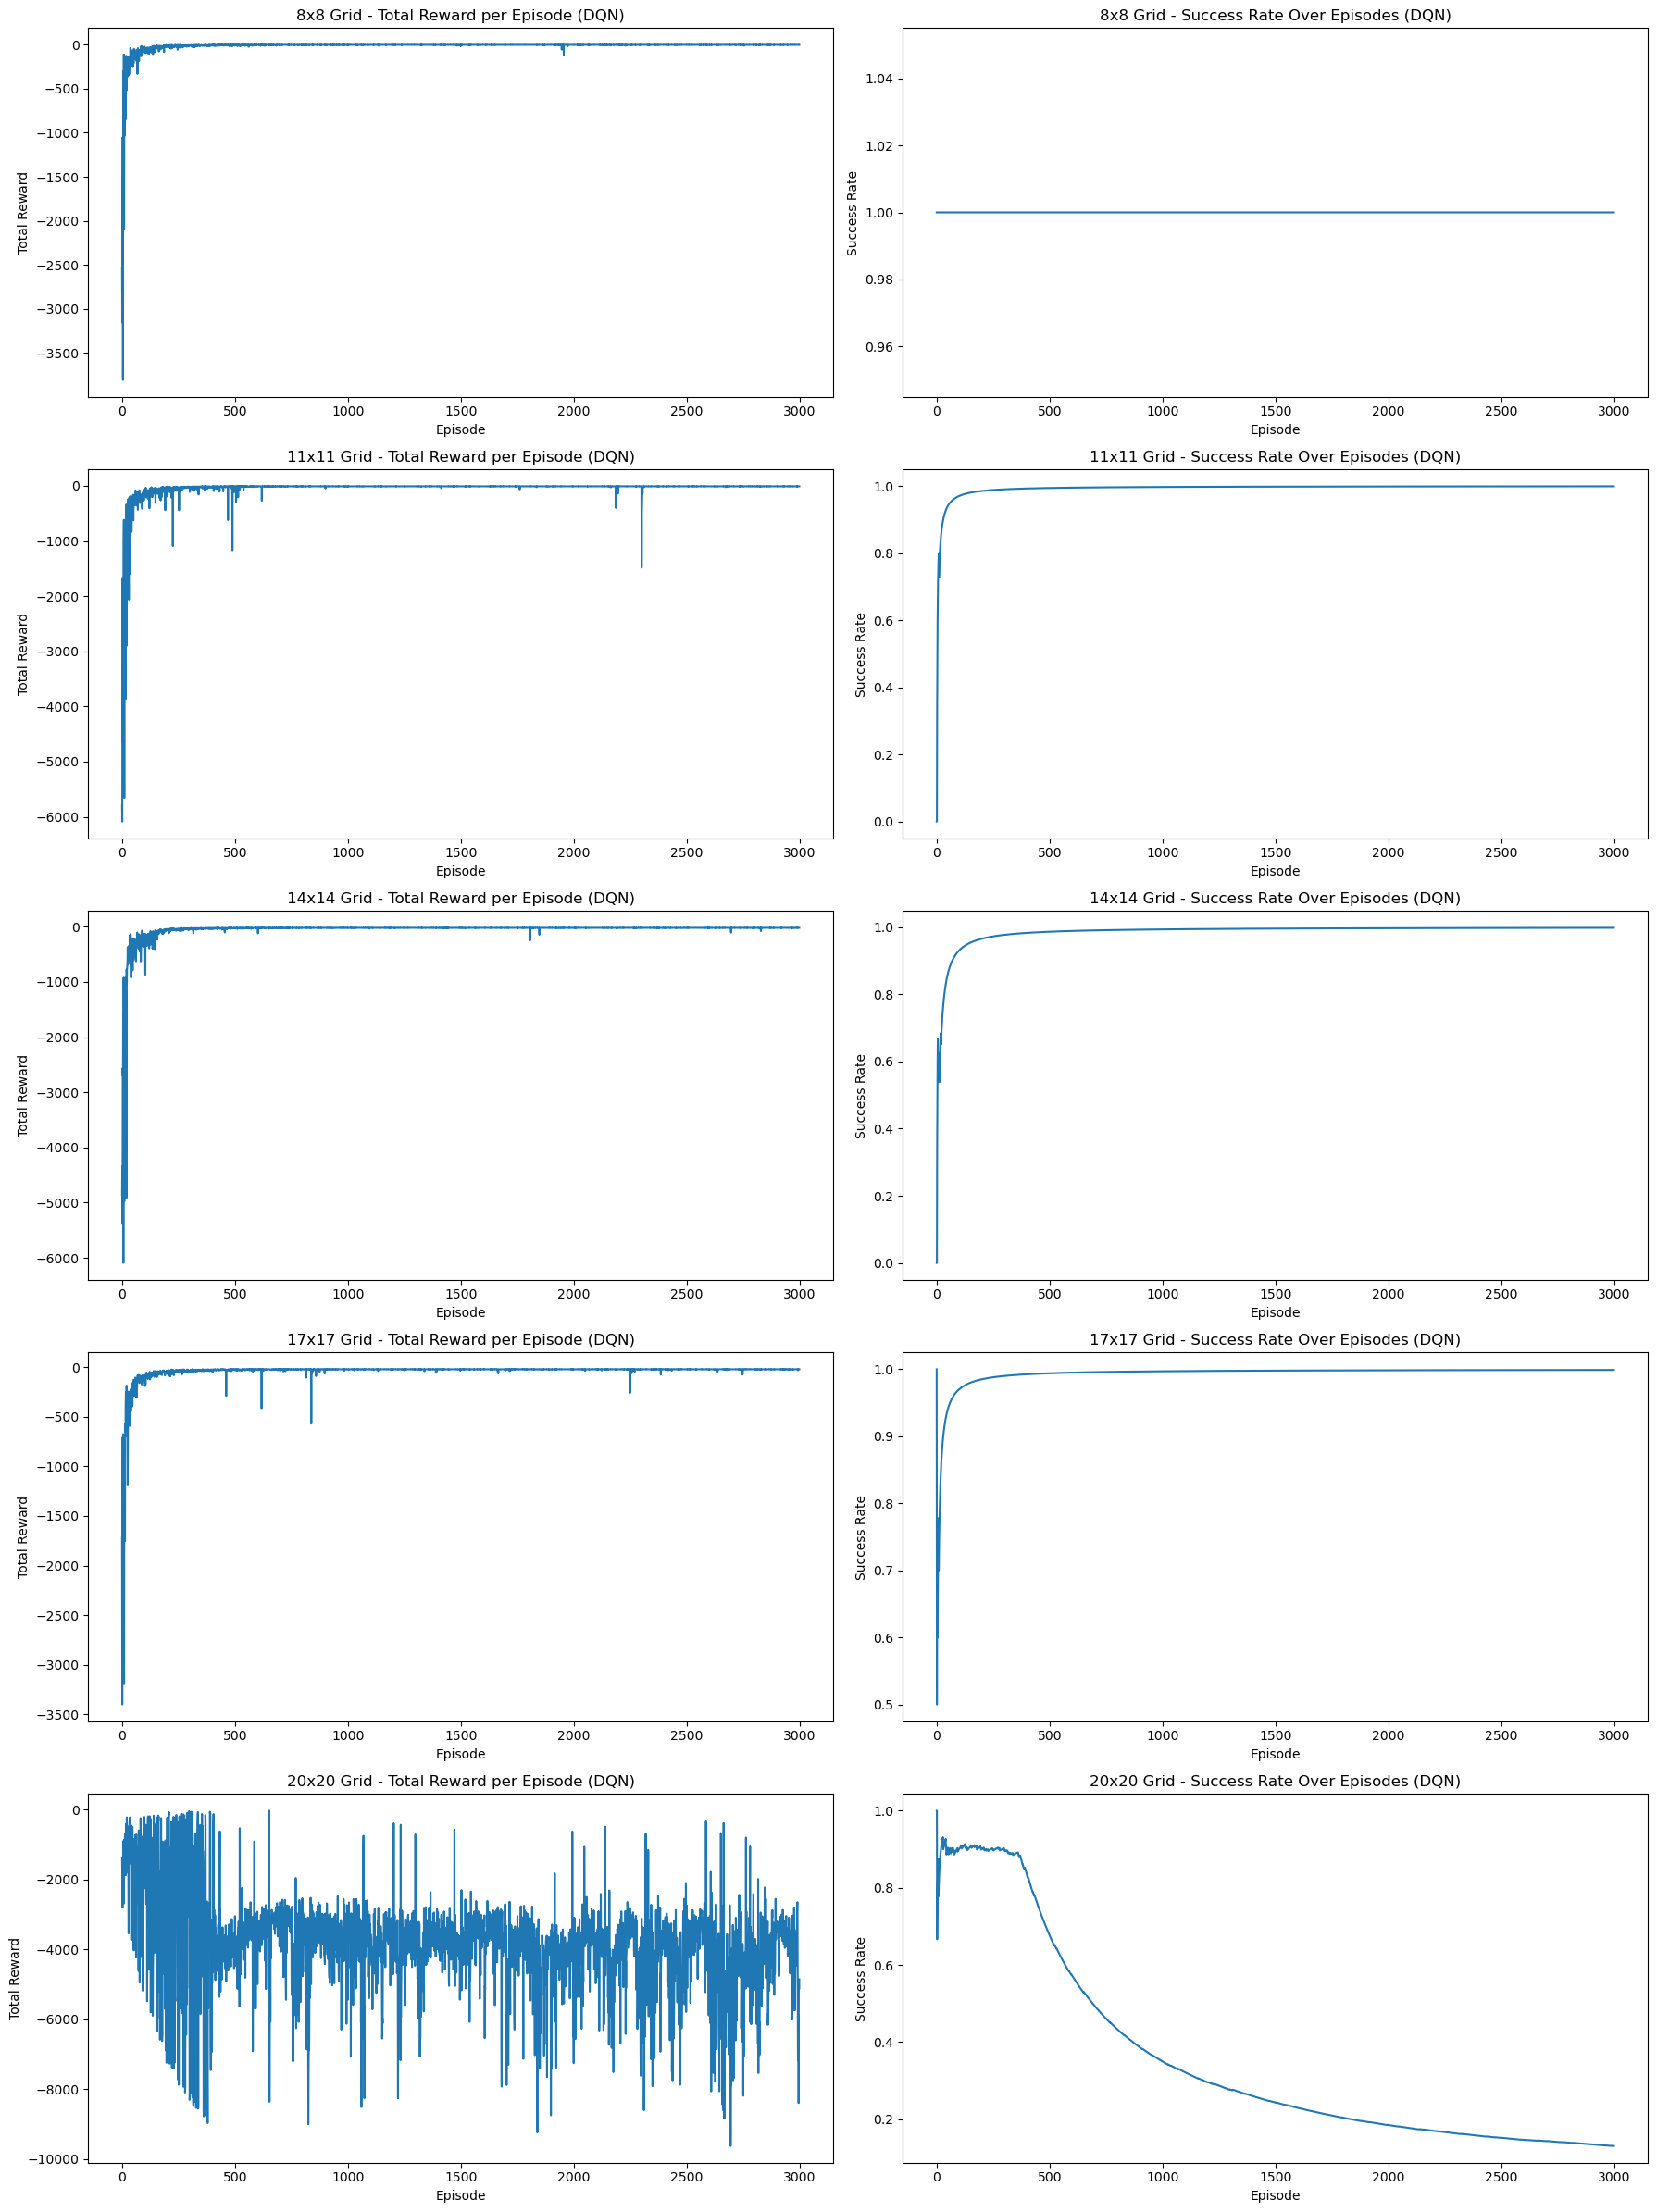

In [238]:
grids = {
    "8x8" : create_grid_8x8(),
    "11x11" : create_grid_11x11(),
    "14x14" : create_grid_14x14(),
    "17x17" : create_grid_17x17(),
    "20x20" : create_grid_20x20()
}

results = {}
state_dim = 2   # Using (row, col) as state representation
action_dim = 4  # actions: up, right, down, left
for grid_name, grid in grids.items():
    print(f"Training DQN on {grid_name} grid...")
    env = GridWorldEnv(grid)
    agent = DQNAgent(state_dim, action_dim, buffer_capacity=10000, batch_size=64, gamma=0.99, 
                     lr=1e-3, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, target_update_freq=10)
    rewards, success_rate = train_dqn(env, agent, num_episodes=num_episodes, max_steps=max_steps)
    results[grid_name] = {"rewards": rewards, "success_rate": success_rate}

# Plot
fig, axes = plt.subplots(len(grids), 2, figsize=(18, 24)) 

for idx, grid_name in enumerate(results.keys()):
    rewards = results[grid_name]["rewards"]
    success_rate = results[grid_name]["success_rate"]
    
    axes[idx, 0].plot(rewards)
    axes[idx, 0].set_title(f"{grid_name} Grid - Total Reward per Episode (DQN)")
    axes[idx, 0].set_xlabel("Episode")
    axes[idx, 0].set_ylabel("Total Reward")
    
    axes[idx, 1].plot(success_rate)
    axes[idx, 1].set_title(f"{grid_name} Grid - Success Rate Over Episodes (DQN)")
    axes[idx, 1].set_xlabel("Episode")
    axes[idx, 1].set_ylabel("Success Rate")

plt.tight_layout()
plt.show()

## Double DQN Implementation:

In [239]:
# Replay Buffer for Experience Replay
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

# Q-Network (Neural Network) Definition
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
        
    def forward(self, x):
        return self.fc(x)


### Double DQN Agent:

In [240]:
class DoubleDQNAgent:
    def __init__(self, state_dim, action_dim, buffer_capacity=10000, batch_size=64, gamma=0.99,
                 lr=1e-3, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, target_update_freq=10):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.target_update_freq = target_update_freq
        self.update_count = 0
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayBuffer(buffer_capacity)
        
    def select_action(self, state):
        state_tensor = torch.FloatTensor(np.array(state)).unsqueeze(0).to(self.device)
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_dim)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        return q_values.argmax().item()
    
    def update(self):
        if len(self.memory) < self.batch_size:
            return
        
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)
        
        batch_state = torch.FloatTensor(batch_state).to(self.device)
        batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(self.device)
        batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(self.device)
        batch_next_state = torch.FloatTensor(batch_next_state).to(self.device)
        batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(self.device)
        
        current_q = self.policy_net(batch_state).gather(1, batch_action)
        
        next_q_policy = self.policy_net(batch_next_state)
        next_actions = next_q_policy.argmax(dim=1, keepdim=True)
        next_q_target = self.target_net(batch_next_state).gather(1, next_actions)
        target_q = batch_reward + self.gamma * next_q_target * (1 - batch_done)
        
        loss = nn.MSELoss()(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.update_count += 1
        if self.update_count % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)


### Double DQN Training Function:


In [241]:
def train_double_dqn(env, agent, num_episodes, max_steps):

    rewards_per_episode = []
    success_rate = []
    successes = 0
    
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        step = 0
        
        while not done and step < max_steps:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.memory.push(state, action, reward, next_state, done)
            agent.update()
            state = next_state
            total_reward += reward
            step += 1
        
        agent.decay_epsilon()
        rewards_per_episode.append(total_reward)

        if done and reward == 10:
            successes += 1
        success_rate.append(successes / (episode + 1))
    
    return rewards_per_episode, success_rate


### Training on Different Grid Sizes:


Training Double DQN on 8x8 grid...
Training Double DQN on 11x11 grid...
Training Double DQN on 14x14 grid...
Training Double DQN on 17x17 grid...
Training Double DQN on 20x20 grid...


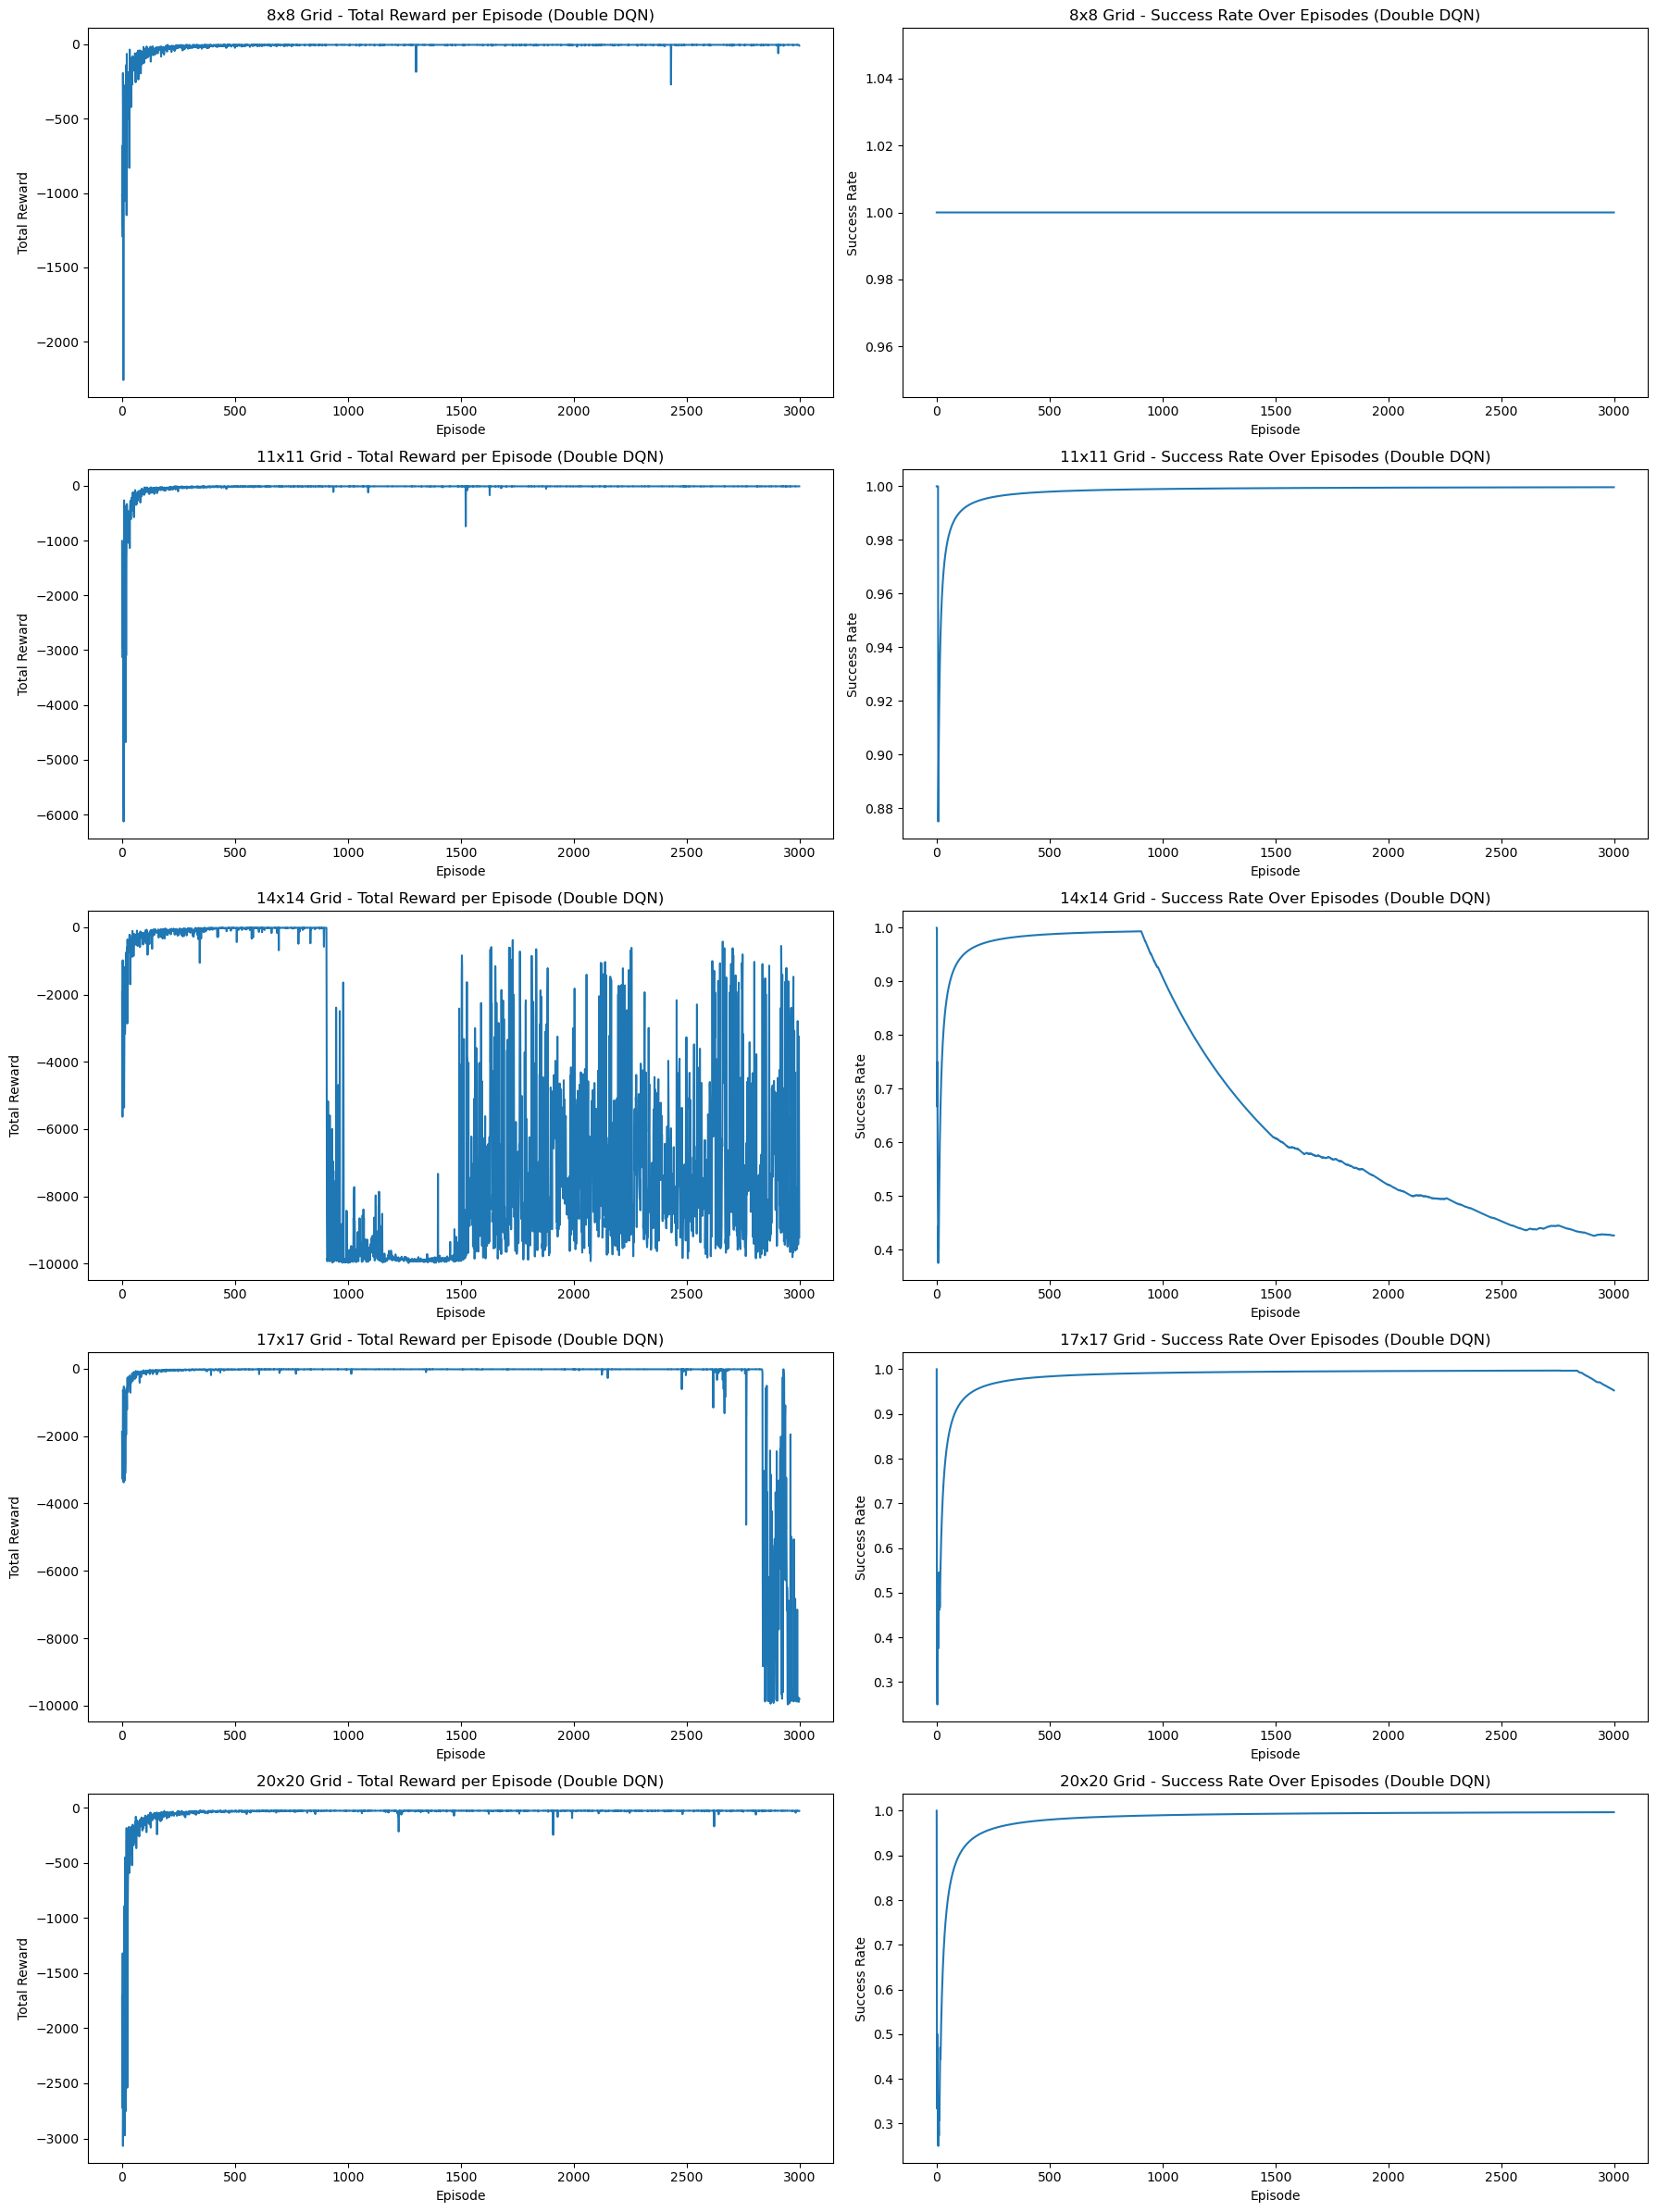

In [242]:
grids = {
    "8x8" : create_grid_8x8(),
    "11x11" : create_grid_11x11(),
    "14x14" : create_grid_14x14(),
    "17x17" : create_grid_17x17(),
    "20x20" : create_grid_20x20()
}

results = {}
state_dim = 2   # (row, col)
action_dim = 4  # up, right, down, left

for grid_name, grid in grids.items():
    print(f"Training Double DQN on {grid_name} grid...")
    env = GridWorldEnv(grid)
    agent = DoubleDQNAgent(state_dim, action_dim, buffer_capacity=10000, batch_size=64, gamma=0.99,
                           lr=1e-3, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, target_update_freq=10)
    rewards, success_rate = train_double_dqn(env, agent, num_episodes=num_episodes, max_steps = max_steps)
    results[grid_name] = {"rewards": rewards, "success_rate": success_rate}

# Plot
fig, axes = plt.subplots(len(grids), 2, figsize=(18, 24))  

for idx, grid_name in enumerate(results.keys()):
    rewards = results[grid_name]["rewards"]
    success_rate = results[grid_name]["success_rate"]
    
    axes[idx, 0].plot(rewards)
    axes[idx, 0].set_title(f"{grid_name} Grid - Total Reward per Episode (Double DQN)")
    axes[idx, 0].set_xlabel("Episode")
    axes[idx, 0].set_ylabel("Total Reward")
    
    axes[idx, 1].plot(success_rate)
    axes[idx, 1].set_title(f"{grid_name} Grid - Success Rate Over Episodes (Double DQN)")
    axes[idx, 1].set_xlabel("Episode")
    axes[idx, 1].set_ylabel("Success Rate")

plt.tight_layout()
plt.show()

---


## Analysis and Comparison

We trained four algorithms—Q-Learning, SARSA, DQN, and Double DQN—on five different grid sizes (8×8, 11×11, 14×14, 17×17, and 20×20) for 3000 episodes each, with up to 2000 steps per episode. Below is a comparison based on:
1. **Convergence Speed** (how fast the agent learns a good policy)  
2. **Final Score** (the total reward once the agent stabilizes)  
3. **Success Rate** (the fraction of episodes that end with the goal reached)

---

### 1. Q-Learning

- **Learning Outcomes:**  
  - In all five grids, Q-Learning eventually converged to around zero total reward, showing that it managed to learn each environment completely.  
  - On smaller grids (8×8, 11×11), because we allowed many steps per episode (2000), the agent almost always reached the goal, even in early episodes.

- **Convergence Speed:**  
  - The algorithm converged faster in smaller grids. As the grid size grew, the fluctuations in the total reward became larger, and it took more episodes to fully learn the environment.

- **Success Rate and Final Score:**  
  - Despite the increased complexity in larger grids, Q-Learning still managed to reach a high success rate given enough episodes.  
  - The final reward values often hovered near zero, indicating that the agent found an efficient path to the goal.

#### Overall Observation
Q-Learning performs well in all grids but needs more episodes and experiences stronger reward fluctuations in bigger, more complex environments.

---

### 2. SARSA

- **Similarity to Q-Learning:**  
  - SARSA’s results and number of steps are very similar to Q-Learning. Both are tabular methods and require a good amount of exploration in large grids.

- **Convergence Behavior:**  
  - Like Q-Learning, SARSA benefits from having many steps per episode in smaller grids, reaching the goal early and stabilizing quickly.  
  - In larger grids, it also shows more fluctuations and requires more episodes to converge.

- **Final Performance:**  
  - It can eventually learn each environment thoroughly, reaching total rewards near zero in smaller grids and improving steadily in bigger ones.

#### Overall Observation
SARSA and Q-Learning behave almost the same in these experiments, though SARSA sometimes updates more smoothly because it uses the actual next action in its update rule.

---

### 3. DQN

- **Performance on Smaller Grids:**  
  - In the first four environments (8×8, 11×11, 14×14, 17×17), DQN learned much faster than the tabular methods. It reached high total rewards in fewer episodes, showing the advantage of using a neural network for function approximation.

- **Issue on 20×20 Grid:**  
  - In the 20×20 environment, DQN failed to learn effectively. The total reward stayed at large negative values and fluctuated significantly.

- **Possible Reasons:**  
  - The environment’s complexity might require more sophisticated hyperparameters or exploration strategies.  
  - The agent could be stuck in local minima, repeatedly visiting certain states and not exploring enough to find the goal.  
  - The neural network might need different settings (like a deeper architecture or different learning rate) to handle such a large grid.

#### Overall Observation
DQN shows clear benefits in medium-sized grids but struggled in the 20×20 environment, possibly due to insufficient exploration or suboptimal hyperparameter choices.

---

### 4. Double DQN

- **Strong Performance on Some Grids:**  
  - For the smaller 8×8 and 11×11 grids, Double DQN performed very well, similar to DQN, and quickly converged to good policies.

- **Sudden Drops in Larger Grids:**  
  - In the 14×14 grid, Double DQN appeared to learn by around episode 900, but then the total reward suddenly dropped and began to fluctuate negatively. A similar drop happened in the 17×17 grid around episode 2800.

- **Possible Explanation:**  
  - The agent’s replay buffer could have shifted toward less helpful experiences, causing it to “forget” its earlier policy.  
  - Overestimation bias might still appear when new states or transitions are sampled, even though Double DQN reduces it more than DQN.  
  - The network might have converged to a suboptimal policy and then struggled to recover, leading to big swings in reward.

- **20×20 Environment Success:**  
  - Surprisingly, Double DQN managed to learn the 20×20 grid very well, stabilizing at a high reward and success rate. This shows that, with the right conditions, Double DQN can handle large environments effectively.

#### Overall Observation
Double DQN generally handles complex environments well, but can experience sudden drops if the training distribution changes or if the agent forgets previously learned strategies. Despite these issues in some grids, it fully mastered the 20×20 environment.

---

### Final Remarks

- **Convergence Speed:**  
  - **Tabular (Q-Learning, SARSA):** Converge well on small grids, need more episodes for large ones.  
  - **Neural (DQN, Double DQN):** Often converge faster on medium or large grids, but can fail if hyperparameters or exploration are not well-tuned (as seen with DQN in 20×20).

- **Final Score (Total Reward):**  
  - **Q-Learning and SARSA:** Tend to hover near zero once they learn the optimal path, but can fluctuate in bigger grids.  
  - **DQN and Double DQN:** Can achieve high rewards quickly. However, DQN completely failed in 20×20, while Double DQN succeeded but had unexpected drops in some other grids.

- **Success Rate:**  
  - **Tabular methods:** Often reach 100% on smaller grids and eventually improve on larger ones.  
  - **DQN and Double DQN:** Usually reach a high success rate faster, except for DQN’s failure on 20×20. Double DQN, on the other hand, performed very well in 20×20 despite challenges in 14×14 and 17×17.

In conclusion, Q-Learning and SARSA are simpler but effective for small to medium grids if given enough episodes. DQN can learn quickly in medium grids but may fail in very large grids without proper tuning. Double DQN can be more stable and handle larger environments, although it can still experience sudden performance drops when the learning process changes abruptly.